**INTRODUCTION**

For this assignment we have to develop of a multilayer perceptron model for classifying grayscale images of Simpsons characters. The goal is to systematically evaluate different configurations to maximize classification accuracy while balancing model complexity and generalization.

By experimenting with different numbers of layers, neuron counts, and regularization strengths and other hyperparameters we will try to determine the optimal set. Additionally, we will test the model's robustness by testing on transformed datasets, including rotated and zoomed images.

Mounting the google drive to store/retrieve data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing keras-tuner, so we can import the library below

In [1]:
!pip install keras-tuner

Importing useful libraries

In [ ]:
import os
import json
import ast

import numpy as np
import pandas as pd
import cv2
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD, AdamW

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.regularizers import l2
from keras.utils import to_categorical

import keras_tuner as kt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import zipfile



Cloning the repository so we can acces the dataset locally

In [ ]:
!git clone https://github.com/alvarobartt/simpsons-mnist.git

Cloning into 'simpsons-mnist'...
remote: Enumerating objects: 20148, done.
remote: Counting objects: 100% (20148/20148), done.
remote: Compressing objects: 100% (20032/20032), done.
remote: Total 20148 (delta 218), reused 20022 (delta 111), pack-reused 0 (from 0)
Receiving objects: 100% (20148/20148), 24.79 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (218/218), done.
Updating files: 100% (20014/20014), done.


After this prepatory work we can load the images in a pandas dataframe. In this dataframe we decided to store the image path and the label corresponding to this image path.

In [ ]:
zip_path_r = "/content/drive/My Drive/test_rotated.zip"
zip_path_zi = "/content/drive/My Drive/test_zoomed_in.zip"
zip_path_zo = "/content/drive/My Drive/test_zoomed_out.zip"

test_rotated_path = "/content/drive/MyDrive/test_rotated"
test_zoomed_in_path = "/content/drive/MyDrive/test_zoomed_in"
test_zoomed_out_path = "/content/drive/MyDrive/test_zoomed_out"

with zipfile.ZipFile(zip_path_r, 'r') as zip_ref:
    zip_ref.extractall(test_rotated_path)

with zipfile.ZipFile(zip_path_zi, 'r') as zip_ref:
    zip_ref.extractall(test_zoomed_in_path)

with zipfile.ZipFile(zip_path_zo, 'r') as zip_ref:
    zip_ref.extractall(test_zoomed_out_path)

In [ ]:

dataset_path = "simpsons-mnist/dataset/grayscale/train/"
test_path = "simpsons-mnist/dataset/grayscale/test/"
test_rotated_path = "/content/drive/MyDrive/test_rotated"
test_zoomed_in_path = "/content/drive/MyDrive/test_zoomed_in"
test_zoomed_out_path = "/content/drive/MyDrive/test_zoomed_out"

image_data = []
test_data = []
test_r_data = []
test_zi_data = []
test_zo_data = []

for class_name in os.listdir(dataset_path):

    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            image_data.append((os.path.join(class_path, img_name), class_name))

df_train = pd.DataFrame(image_data, columns=["image_path", "label"])
print(df_train.head())

for class_name in os.listdir(test_path):

    class_path = os.path.join(test_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            test_data.append((os.path.join(class_path, img_name), class_name))


df_test = pd.DataFrame(test_data, columns=["image_path", "label"])
print(df_test.head())

for class_name in os.listdir(test_rotated_path):

    class_path = os.path.join(test_rotated_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            test_r_data.append((os.path.join(class_path, img_name), class_name))

df_test_r = pd.DataFrame(test_r_data, columns=["image_path", "label"])
print(df_test_r.head())

for class_name in os.listdir(test_zoomed_in_path):

    class_path = os.path.join(test_zoomed_in_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            test_zi_data.append((os.path.join(class_path, img_name), class_name))

df_test_zi = pd.DataFrame(test_zi_data, columns=["image_path", "label"])
print(df_test_zi.head())

for class_name in os.listdir(test_zoomed_out_path):

    class_path = os.path.join(test_zoomed_out_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            test_zo_data.append((os.path.join(class_path, img_name), class_name))

df_test_zo = pd.DataFrame(test_zo_data, columns=["image_path", "label"])
print(df_test_zo.head())

                                          image_path                     label
0  simpsons-mnist/dataset/grayscale/train/charles...  charles_montgomery_burns
1  simpsons-mnist/dataset/grayscale/train/charles...  charles_montgomery_burns
2  simpsons-mnist/dataset/grayscale/train/charles...  charles_montgomery_burns
3  simpsons-mnist/dataset/grayscale/train/charles...  charles_montgomery_burns
4  simpsons-mnist/dataset/grayscale/train/charles...  charles_montgomery_burns
                                          image_path                     label
0  simpsons-mnist/dataset/grayscale/test/charles_...  charles_montgomery_burns
1  simpsons-mnist/dataset/grayscale/test/charles_...  charles_montgomery_burns
2  simpsons-mnist/dataset/grayscale/test/charles_...  charles_montgomery_burns
3  simpsons-mnist/dataset/grayscale/test/charles_...  charles_montgomery_burns
4  simpsons-mnist/dataset/grayscale/test/charles_...  charles_montgomery_burns
                                          image_path

Now we can load the image using the image path from the previous dataframe, meaning that we just load in the pixel values from the image. We use "cv2.IMREAD_GRAYSCALE" to make sure the image are loaded in grayscale.

In [ ]:

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255.0
    return img


df_train["image_array"] = df_train["image_path"].apply(lambda x: load_image(x))

df_test["image_array"] = df_test["image_path"].apply(lambda x: load_image(x))

df_test_r["image_array"] = df_test_r["image_path"].apply(lambda x: load_image(x))

df_test_zi["image_array"] = df_test_zi["image_path"].apply(lambda x: load_image(x))

df_test_zo["image_array"] = df_test_zo["image_path"].apply(lambda x: load_image(x))


sample_img = df_train["image_array"][0]
print(sample_img.shape)


(28, 28)


We calculate the number of classes we need so we can set the amount of output neurons we need later.

In [ ]:
num_classes = df_train.label.nunique()
print(num_classes)


10


Before we can run our model we still have to split the data in training and validation data. The test data is already separated (20%), so we split the remaining data with a 70-30 split. We finetuned our batch size and number of epochs and found that these values give good results (we use early stopping so in general less epochs are used). We also encode the labels, meaning that each simson character will correspond to a number 0-9.

In [ ]:


batch_size = 64
epochs = 250



label_encoder = LabelEncoder()
df_train["label_encoded"] = label_encoder.fit_transform(df_train["label"])
df_test["label_encoded"] = label_encoder.transform(df_test["label"])
df_test_r["label_encoded"] = label_encoder.transform(df_test_r["label"])
df_test_zi["label_encoded"] = label_encoder.transform(df_test_zi["label"])
df_test_zo["label_encoded"] = label_encoder.transform(df_test_zo["label"])



X_train_valid = np.stack(df_train["image_array"].values)


y_train_valid = to_categorical(df_train["label_encoded"], num_classes=num_classes)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.3, random_state=42)

X_test = np.stack(df_test["image_array"].values)
y_test = to_categorical(df_test["label_encoded"], num_classes=num_classes)

X_test_r = np.stack(df_test_r["image_array"].values)
y_test_r = to_categorical(df_test_r["label_encoded"], num_classes=num_classes)

X_test_zi = np.stack(df_test_zi["image_array"].values)
y_test_zi = to_categorical(df_test_zi["label_encoded"], num_classes=num_classes)

X_test_zo = np.stack(df_test_zo["image_array"].values)
y_test_zo = to_categorical(df_test_zo["label_encoded"], num_classes=num_classes)


print(X_train_valid.shape)
print(y_train_valid.shape)



(8000, 28, 28)
(8000, 10)


**MODEL SELECTION**

We decided to try 3 different approaches to find the best hyperparameters: Grid Search, Random Search and Bayesian Optimization. To try and keep the choice of our model unbiased we used the same amount of trials and epochs for each model (288 and 250). The models were run locally, after which we loaded in the csv files with the results (both model and csv files are shown below). AdamW was our choice for the optimizer as it has useful properties with regards to lowering the learning rate when a plateau is reached.




*GRID SEARCH*

After testing several combinations of hyperparameters manually, we decided to search for a model with 1-6 layers, 16-128 neurons per layer and L2 regularization between 0.0005 and 0.01. The best model reached a validation accuracy of 0.4004 (5 layers, 112 neurons per layer, and 0.0005 L2). A simpler model (3 layers, 96 neurons per layer, and 0.0005 L2) managed to get a slightly lower validation accuracy of 0.3967. We decided to also test this model since the lower complexity could potentially generalize better on completely unseen data.

In [ ]:
num_layers_options = list(range(1, 7))
neurons_options = list(range(16, 129, 16))
regs = [0.0005, 0.001, 0.0015, 0.0025, 0.005, 0.01]

hyperparameter_combinations = list(itertools.product(num_layers_options, neurons_options, regs))

best_model = None
best_val_acc = 0
best_hyperparams = None

results_G = []

for num_layers, neurons, reg in hyperparameter_combinations:
    print(f"\nTesting Model with {num_layers} layers, {neurons} neurons, L2={reg}")

    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    for _ in range(num_layers):
        model.add(Dense(units=neurons, kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())

    model.add(Dense(10, activation="softmax"))

    optimizer = AdamW()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=250,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )

    best_epoch = np.argmax(history.history['val_accuracy'])
    train_acc = history.history['accuracy'][best_epoch]
    val_acc = history.history['val_accuracy'][best_epoch]
    print(f"Model Validation Accuracy: {val_acc:.4f}")

    results_G.append({
        "num_layers": num_layers,
        "neurons": neurons,
        "l2_reg": reg,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_hyperparams = (num_layers, neurons, reg)

df_results_G = pd.DataFrame(results_G)

print("\nBest Model Found:")
print(f"Layers: {best_hyperparams[0]}, Neurons: {best_hyperparams[1]}, L2 Regularization: {best_hyperparams[2]}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

*RANDOM SEARCH*

Since allowing every layer to have a unique amount of neurons would not be a feasible approach for a grid search in our case, we decided to test whether we could find a better model by using a random search which allows that. From the results of the grid search we could also see that almost every model performed best with an L2 regularization score of 0.0005, which is why we set this seemingly optimal value. Although a better model was not found, the performance of the best model was only slightly lower (0.3979 validation accuracy). This model had 4 layers and 128, 112, 48, and 128 neurons in every layer.

In [ ]:
num_layers_options = list(range(1, 7))
neurons_options = list(range(16, 129, 16))

num_random_samples = 288

best_model = None
best_val_acc = 0
best_hyperparams = None

results_R = []

for _ in range(num_random_samples):
    num_layers = random.choice(num_layers_options)
    neurons_per_layer = [random.choice(neurons_options) for _ in range(num_layers)]
    reg = 0.0005

    print(f"\nTesting Model with {num_layers} layers, Neurons: {neurons_per_layer}")

    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    for neurons in neurons_per_layer:
        model.add(Dense(units=neurons, kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())

    model.add(Dense(10, activation="softmax"))

    optimizer = AdamW()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=250,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )

    best_epoch = np.argmax(history.history['val_accuracy'])
    train_acc = history.history['accuracy'][best_epoch]
    val_acc = history.history['val_accuracy'][best_epoch]
    print(f"Model Validation Accuracy: {val_acc:.4f}")

    results_R.append({
        "num_layers": num_layers,
        "neurons": neurons_per_layer,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_hyperparams = (num_layers, neurons_per_layer)

df_results_R = pd.DataFrame(results_R)

print("\nBest Model Found:")
print(f"Layers: {best_hyperparams[0]}, Neurons: {best_hyperparams[1]}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

*BAYESIAN OPTIMIZATION*

The decision to run a Bayesian optimization was identical to the one of the random search, this time allowing the model even more freedom by searching over a continuous range for L2. With a validation accuracy of only 0.3592, it seems like a local optimum was reached. This model only had 1 layer with 128 neurons and an L2 of 0.0005.

In [ ]:


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    num_layers = hp.Int('num_layers', min_value=1, max_value=6)
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        reg = hp.Float(f'reg{i}', min_value=0.0005, max_value=0.01)
        model.add(Dense(units=units, kernel_regularizer=l2(reg)))
        model.add(LeakyReLU())

    model.add(Dense(10, activation="softmax"))

    optimizer = AdamW()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=288,
    directory='mlp_tuning_dir',
    project_name=f"mlp_bayesian_search_leakyrelu_1734_64"
)

tuner.search(
    X_train, y_train,
    epochs=250,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
)

all_trials = []
for trial in tuner.oracle.trials.values():

    trial_hps = trial.hyperparameters.values
    layers = trial_hps.get("num_layers", None)

    reg_values = [trial_hps.get(f"reg{i}", None) for i in range(6)]
    unit_values = [trial_hps.get(f"units_{i}", None) for i in range(6)]

    trial_best_val_acc = trial.metrics.get_best_value("val_accuracy")
    trial_best_epoch = trial.metrics.get_best_step("val_accuracy")


    trial_model = tuner.hypermodel.build(trial.hyperparameters)
    history = trial_model.fit(
        X_train, y_train,
        epochs=trial_best_epoch + 1,
        batch_size=64,
        validation_data=(X_valid, y_valid),
        verbose=0
    )

    trial_best_train_acc = history.history["accuracy"][trial_best_epoch]

    all_trials.append({
        "num_layers": layers,
        **{f"reg{i}": reg_values[i] for i in range(6)},
        **{f"units_{i}": unit_values[i] for i in range(6)},
        "best_val_accuracy": trial_best_val_acc,
        "best_train_accuracy": trial_best_train_acc,
        "best_epoch": trial_best_epoch
    })

df_trials = pd.DataFrame(all_trials)

df_trials_bayes_json = df_trials.to_json("all_trials_results_bayes.json", orient='records', indent=4)
df_trials_bayes_csv =  df_trials.to_csv("all_trials_results_bayes.csv")

with open("/content/drive/My Drive/df_trials_bayes_json.json", "w") as f:
    json.dump(df_trials_bayes_json, f, indent=4)

with open("/content/drive/My Drive/df_trials_bayes_csv.csv", "w") as f:
    json.dump(df_trials_bayes_csv, f, indent=4)



print("All trial results saved successfully in JSON and CSV!")


Trial 288 Complete [00h 00m 52s]
val_accuracy: 0.3095833361148834

Best val_accuracy So Far: 0.3591666519641876
Total elapsed time: 03h 19m 55s
All trial results saved successfully in JSON and CSV!


In [ ]:
with open("/content/drive/My Drive/Grid_Search_Assignment1.csv", "r") as f:
    grid_search_results = pd.read_csv(f)


In [ ]:
with open("/content/drive/My Drive/Random_Search_Assignment1.csv", "r") as f:
    random_search_results = pd.read_csv(f)

In [ ]:
with open("/content/drive/My Drive/all_trials_results_bayes.csv", "r") as f:
    bayesian_search_results = pd.read_csv(f)
bayesian_search_results.head()

,num_layers,reg0,reg1,reg2,reg3,reg4,reg5,units_0,units_1,units_2,units_3,units_4,units_5,best_val_accuracy,best_train_accuracy,best_epoch
0,1,0.004953,NaN,NaN,NaN,NaN,NaN,80,NaN,NaN,NaN,NaN,NaN,0.291250,0.349821,20
1,4,0.007209,0.000500,0.000500,0.000500,NaN,NaN,128,16.0,16.0,16.0,NaN,NaN,0.307500,0.372143,65
2,5,0.009854,0.006883,0.007791,0.009482,0.000500,NaN,64,80.0,16.0,16.0,16.0,NaN,0.248750,0.245000,33
3,1,0.001533,0.002914,0.009000,0.000782,0.005089,NaN,112,64.0,64.0,16.0,128.0,NaN,0.327917,0.470000,38
4,5,0.004370,0.001621,0.005378,0.006141,0.007150,NaN,128,64.0,16.0,112.0,32.0,NaN,0.275000,0.281071,24


**PLOTTING RESULTS**

*PLOTTING THE GRID SEARCH RESULTS*

As we can see from the plots below, the optimal value for the number of layers seems to be 3-5, with 96-128 neurons per layer. Increasing the L2 regularization score from 0.0005 gave us worse results.
Finally we can see that the majority of the models have a training accuracy which is considerably higher than the validation accuracy (sometimes more than double). This begs the question as to how generalizable these models are.

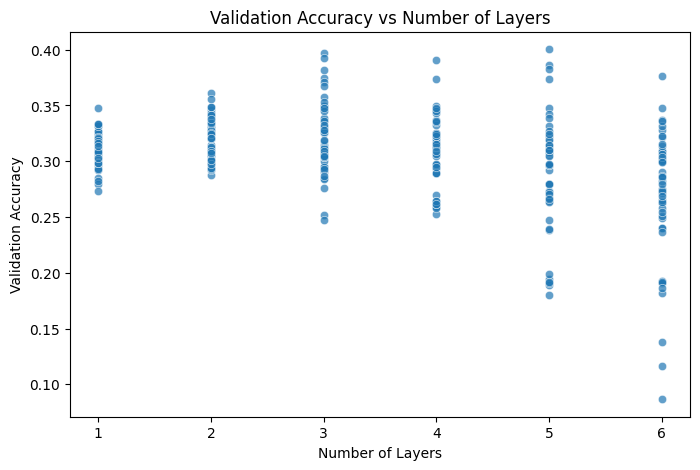

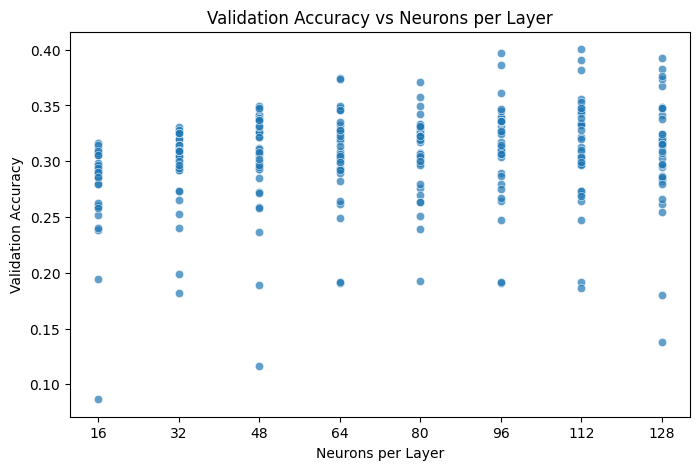

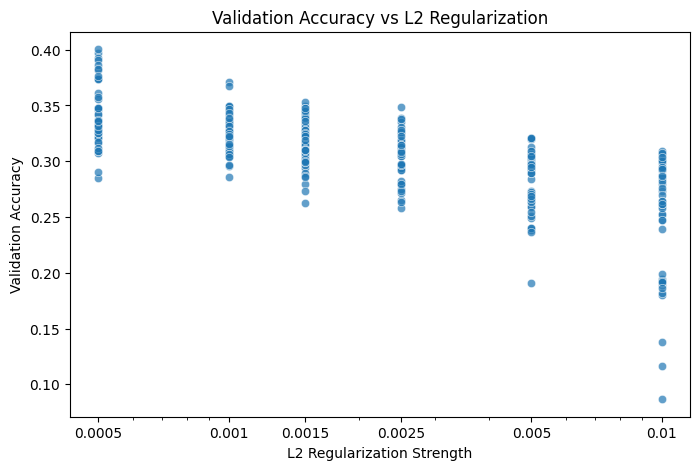

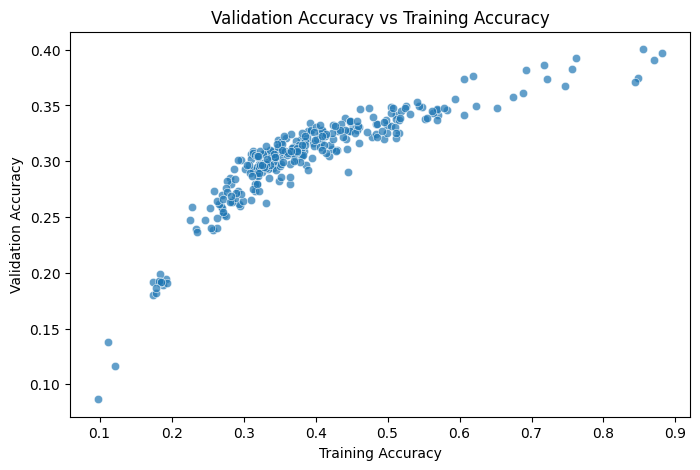

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=grid_search_results["num_layers"], y=grid_search_results["val_acc"], alpha=0.7)
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Layers")
plt.show()

neurons_values = sorted(grid_search_results["neurons"].unique())
plt.figure(figsize=(8, 5))
sns.scatterplot(x=grid_search_results["neurons"], y=grid_search_results["val_acc"], alpha=0.7)
plt.xticks(neurons_values, labels=[f"{val:.4g}" for val in neurons_values])
plt.xlabel("Neurons per Layer")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Neurons per Layer")
plt.show()

l2_values = sorted(grid_search_results["l2_reg"].unique())
plt.figure(figsize=(8, 5))
sns.scatterplot(x=grid_search_results["l2_reg"], y=grid_search_results["val_acc"], alpha=0.7)
plt.xscale("log")
plt.xticks(l2_values, labels=[f"{val:.4g}" for val in l2_values])
plt.xlabel("L2 Regularization Strength")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs L2 Regularization")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=grid_search_results["train_acc"], y=grid_search_results["val_acc"], alpha=0.7)
plt.xlabel("Training Accuracy")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Training Accuracy")
plt.show()


*PLOTTING THE RANDOM SEARCH RESULTS*

Again we can see the optimal number of layers being 3-5, with an upwards trend in accuracy when more neurons are used, however this trend is not strong and has a high variance. The relationship between the training and validation accuracy is similar, although this time the relationship seems to be more linear.

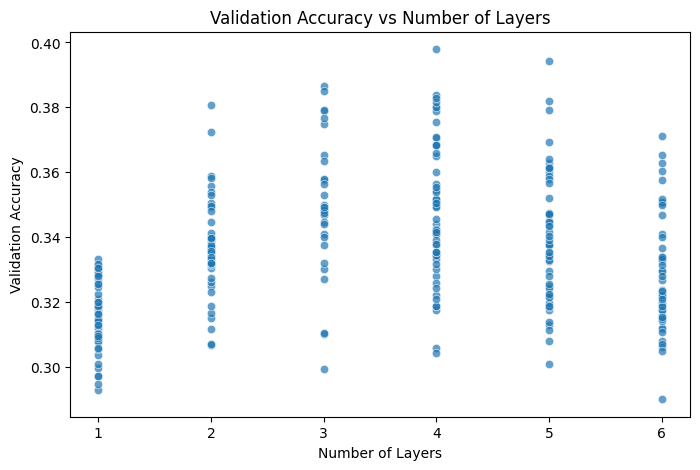

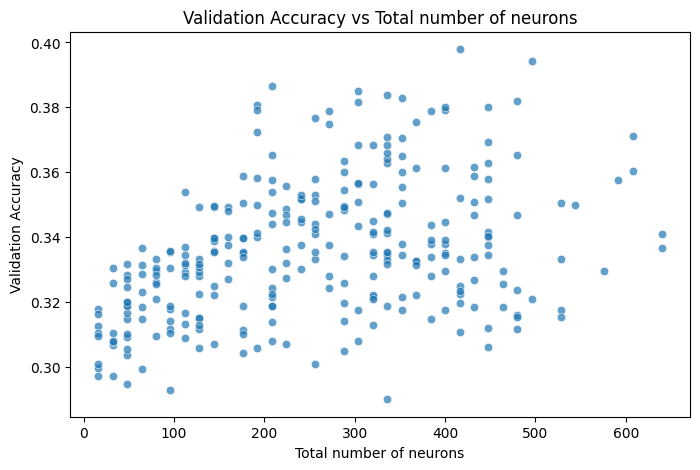

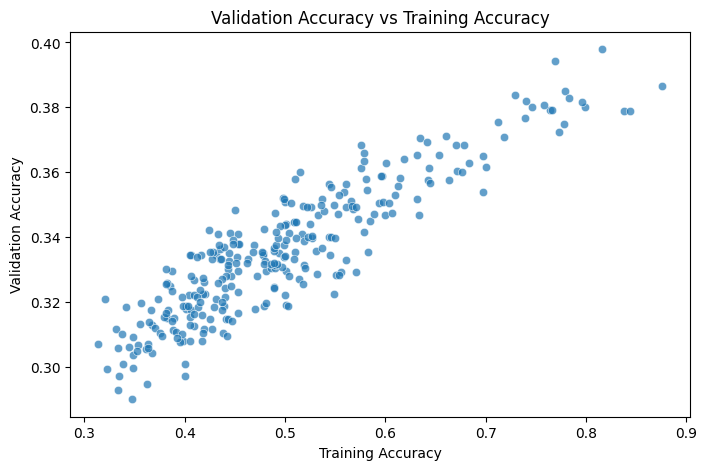

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=random_search_results["num_layers"], y=random_search_results["val_acc"], alpha=0.7)
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Layers")
plt.show()

if isinstance(random_search_results["neurons"].iloc[0], str):
    random_search_results["neurons"] = random_search_results["neurons"].apply(ast.literal_eval)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=random_search_results["neurons"].apply(sum), y=random_search_results["val_acc"], alpha=0.7)
plt.xlabel("Total number of neurons")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Total number of neurons")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=random_search_results["train_acc"], y=random_search_results["val_acc"], alpha=0.7)
plt.xlabel("Training Accuracy")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Training Accuracy")
plt.show()


*PLOTTING THE BAYESIAN RESULTS*

Contrary to our previous results, the Bayesian search seems to find 1 layer optimal. We can see this clearly when we plot the validation accuracy on the number of layers, where a noticeable decrease is shown. It is also interesting to note that after around 100 trials the validation accuracy only increases marginally, which we assume is due to it finding a local optimum. Since the previous searches gave us better results, we believe their results are more reliable.

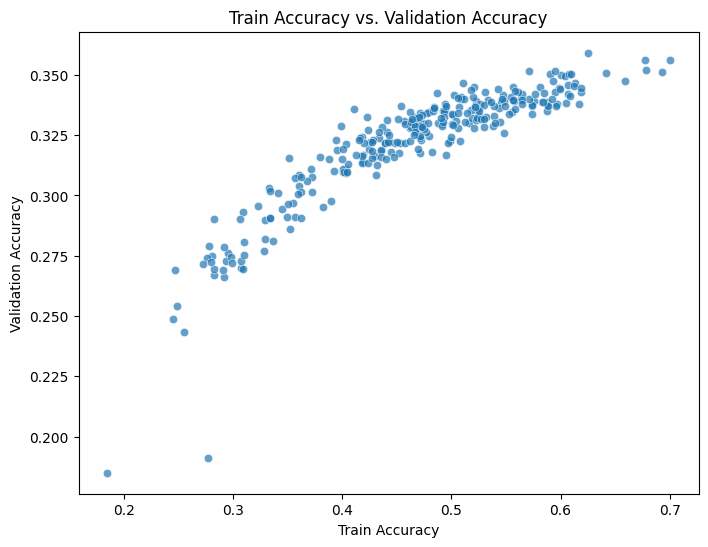

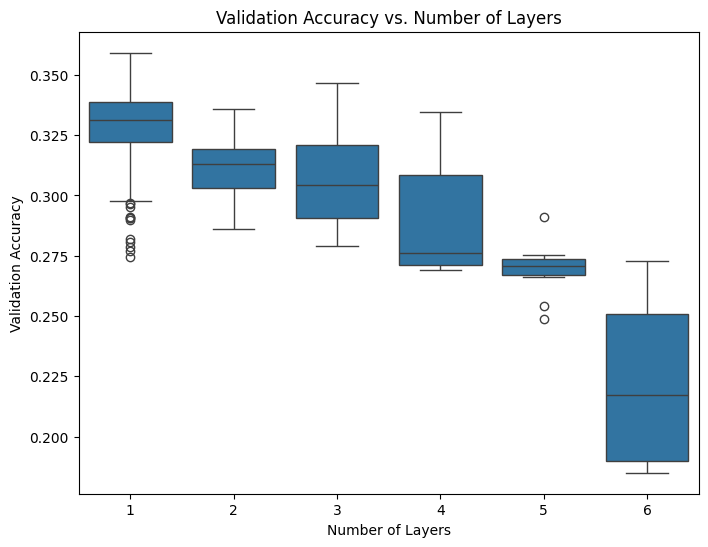

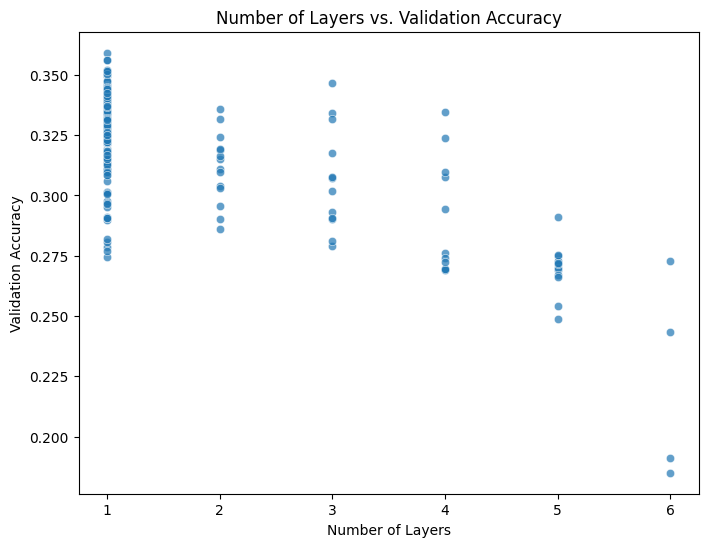

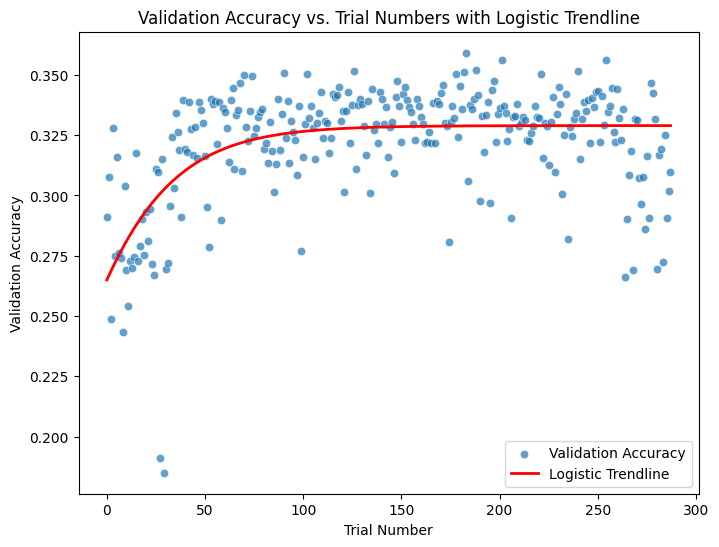

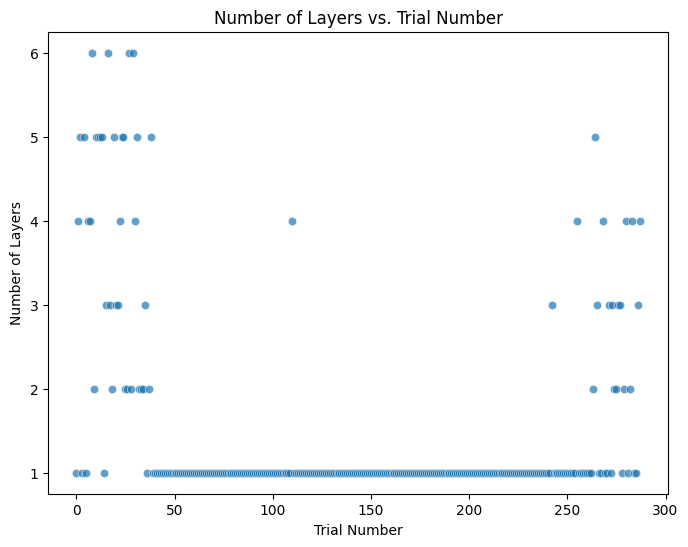

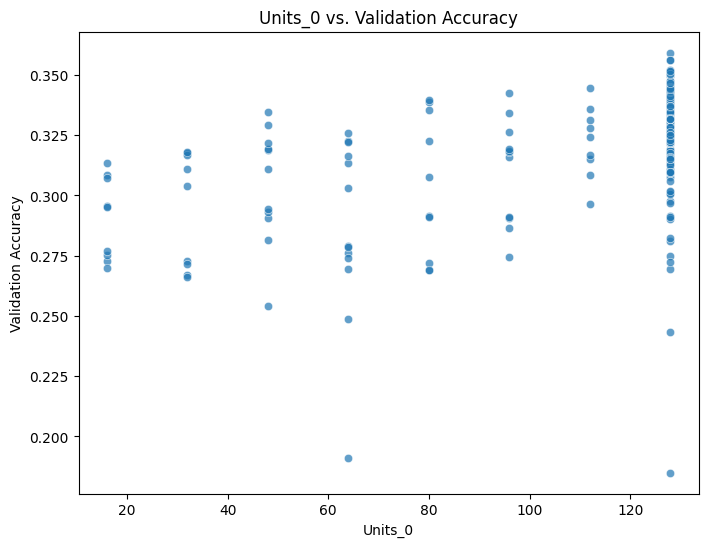

In [ ]:
df_bayes = bayesian_search_results

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_bayes["best_train_accuracy"], y=df_bayes["best_val_accuracy"], alpha=0.7)
plt.xlabel("Train Accuracy")
plt.ylabel("Validation Accuracy")
plt.title("Train Accuracy vs. Validation Accuracy")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_bayes["num_layers"], y=df_bayes["best_val_accuracy"])
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Number of Layers")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_bayes["num_layers"], y=df_bayes["best_val_accuracy"], alpha=0.7)
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.title("Number of Layers vs. Validation Accuracy")
plt.show()

def logistic(x, A, B, C):
    return A / (1 + np.exp(-B * (x - C)))

x_data = df_bayes.index.values
y_data = df_bayes["best_val_accuracy"].values

popt, _ = curve_fit(logistic, x_data, y_data, maxfev=10000)

x_smooth = np.linspace(x_data.min(), x_data.max(), 300)
y_smooth = logistic(x_smooth, *popt)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_data, y=y_data, label="Validation Accuracy", alpha=0.7)

plt.plot(x_smooth, y_smooth, color="red", linewidth=2, label="Logistic Trendline")
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Trial Numbers with Logistic Trendline")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_bayes.index, y=df_bayes["num_layers"], alpha=0.7)
plt.xlabel("Trial Number")
plt.ylabel("Number of Layers")
plt.title("Number of Layers vs. Trial Number")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_bayes["units_0"], y=df_bayes["best_val_accuracy"], alpha=0.7)
plt.xlabel("Units_0")
plt.ylabel("Validation Accuracy")
plt.title("Units_0 vs. Validation Accuracy")
plt.show()


*BUILDING THE FINAL MODELS*

Next to the best model that we found using all 3 searches, we also decided to test the second best model from the grid search along with the best models from both the random search and Bayesian search. These models are reconstructed and trained below.

In [ ]:
def MLPModel_Grid1(num_classes):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))

    model.add(Dense(num_classes, activation="softmax"))

    optimizer = AdamW()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def MLPModel_Grid2(num_classes):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())
    model.add(Dense(96, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(96, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(96, activation="leaky_relu", kernel_regularizer = l2(0.0005)))

    model.add(Dense(num_classes, activation="softmax"))

    optimizer = AdamW()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def MLPModel_Random(num_classes):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())
    model.add(Dense(128, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(112, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(48, activation="leaky_relu", kernel_regularizer = l2(0.0005)))
    model.add(Dense(128, activation="leaky_relu", kernel_regularizer = l2(0.0005)))

    model.add(Dense(num_classes, activation="softmax"))

    optimizer = AdamW()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
def MLPModel_Bayesian(num_classes):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())
    model.add(Dense(128, activation="leaky_relu", kernel_regularizer = l2(0.0005)))

    model.add(Dense(num_classes, activation="softmax"))

    optimizer = AdamW()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model_grid1 = MLPModel_Grid1(num_classes)
model_grid2 = MLPModel_Grid2(num_classes)
model_random = MLPModel_Random(num_classes)
model_bayesian = MLPModel_Bayesian(num_classes)

In [ ]:
model_grid1 = MLPModel_Grid1(num_classes)
model_grid2 = MLPModel_Grid2(num_classes)
model_random = MLPModel_Random(num_classes)
model_bayesian = MLPModel_Bayesian(num_classes)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

history_g1 = model_grid1.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size, callbacks=[early_stopping])
history_g2 = model_grid2.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size, callbacks=[early_stopping])
history_r = model_random.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size, callbacks=[early_stopping])
history_b = model_bayesian.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size, callbacks=[early_stopping])



Epoch 1/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1212 - loss: 2.6072 - val_accuracy: 0.1733 - val_loss: 2.4850
Epoch 2/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2031 - loss: 2.4337 - val_accuracy: 0.2125 - val_loss: 2.3904
Epoch 3/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2346 - loss: 2.3512 - val_accuracy: 0.2092 - val_loss: 2.3644
Epoch 4/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2434 - loss: 2.3062 - val_accuracy: 0.2438 - val_loss: 2.2903
Epoch 5/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2540 - loss: 2.2658 - val_accuracy: 0.2617 - val_loss: 2.2452
Epoch 6/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2750 - loss: 2.2018 - val_accuracy: 0.2637 - val_loss: 2.2451
Epoch 7/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2939 - loss: 2.1704 - val_accuracy: 0.2850 - val_loss: 2.1724
Epoch 8/250
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3158 - loss: 2.1155 - val_accuracy: 0.2496 - 

**RESULTS**


*TEST ACCURACY*

As expected every model performed slightly worse on the test set than on the validation set. The model with the highest validation accuracy also achieved the highest test accuracy.

In [ ]:
loss_g1, accuracy_g1 = model_grid1.evaluate(X_test, y_test)
print(f"Test Accuracy G1: {accuracy_g1:.4f}")
loss_g2, accuracy_g2 = model_grid2.evaluate(X_test, y_test)
print(f"Test Accuracy G2: {accuracy_g2:.4f}")
loss_r, accuracy_r = model_random.evaluate(X_test, y_test)
print(f"Test Accuracy R: {accuracy_r:.4f}")
loss_b, accuracy_b = model_bayesian.evaluate(X_test, y_test)
print(f"Test Accuracy B: {accuracy_b:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3292 - loss: 2.5971
Test Accuracy G1: 0.3730
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3519 - loss: 2.2464
Test Accuracy G2: 0.3660
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3640 - loss: 2.2293
Test Accuracy R: 0.3590
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3677 - loss: 2.0605
Test Accuracy B: 0.3255


*CONFUSION MATRIX*

The first confusion matrix represents the classification of the first Grid Search. The model shows strong performance in identifying certain classes, as seen by the high values along the diagonal. We notice that the confusion matrix is relatively evenly spread across all the labels, meaning that the model isn't overconfident that it can identify some labels.

Label 3 seems to be the hardest to predict. This is rather interesting since Krusty the clown is associated with this label. He is a character that seems easily recognizable to the human eye. Label 0 (Bart Simpson) and label 4 (Lisa Simpson) get confused often as well.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


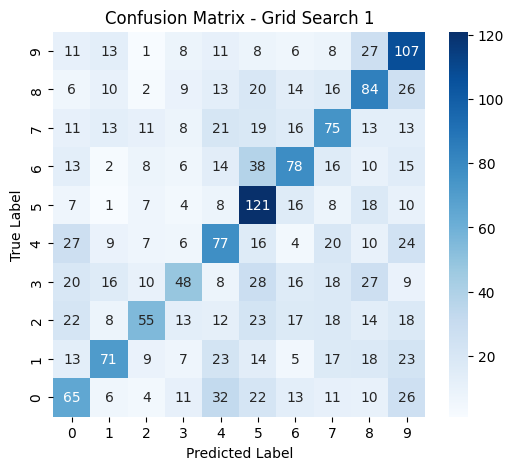

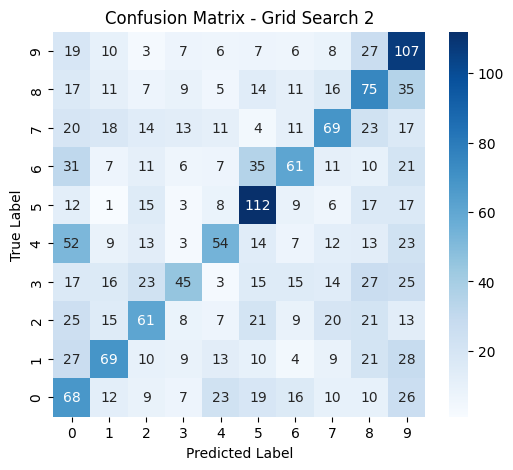

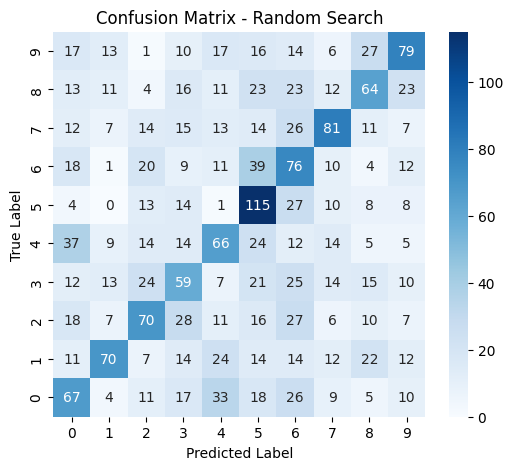

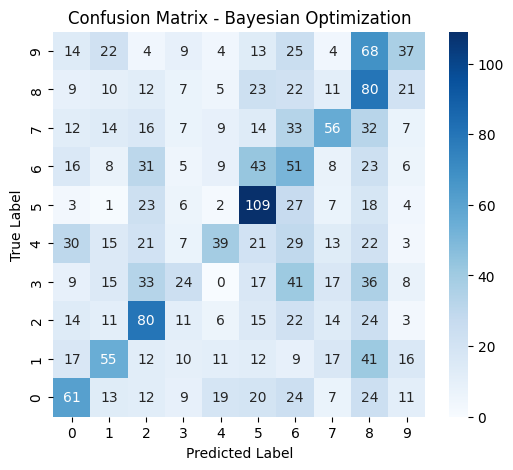

Classification Report - Grid Search 1:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33       200
           1       0.48      0.35      0.41       200
           2       0.48      0.28      0.35       200
           3       0.40      0.24      0.30       200
           4       0.35      0.39      0.37       200
           5       0.39      0.60      0.48       200
           6       0.42      0.39      0.41       200
           7       0.36      0.38      0.37       200
           8       0.36      0.42      0.39       200
           9       0.39      0.54      0.45       200

    accuracy                           0.39      2000
   macro avg       0.40      0.39      0.38      2000
weighted avg       0.40      0.39      0.38      2000

Classification Report - Grid Search 2:
               precision    recall  f1-score   support

           0       0.24      0.34      0.28       200
           1       0.41      0.34      0.38       20

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true),  yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.gca().invert_yaxis()
    plt.show()

y_pred_g1 = np.argmax(model_grid1.predict(X_test), axis=1)
y_pred_g2 = np.argmax(model_grid2.predict(X_test), axis=1)
y_pred_r = np.argmax(model_random.predict(X_test), axis=1)
y_pred_b = np.argmax(model_bayesian.predict(X_test), axis=1)

if y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

plot_confusion_matrix(y_test_labels, y_pred_g1, "Grid Search 1")
plot_confusion_matrix(y_test_labels, y_pred_g2, "Grid Search 2")
plot_confusion_matrix(y_test_labels, y_pred_r, "Random Search")
plot_confusion_matrix(y_test_labels, y_pred_b, "Bayesian Optimization")

print("Classification Report - Grid Search 1:\n", classification_report(y_test_labels, y_pred_g1))
print("Classification Report - Grid Search 2:\n", classification_report(y_test_labels, y_pred_g2))
print("Classification Report - Random Search:\n", classification_report(y_test_labels, y_pred_r))
print("Classification Report - Bayesian Optimization:\n", classification_report(y_test_labels, y_pred_b))


*LOSS CURVE*

As we can see from the loss curves, our first three models have a higher loss than the minimum validation loss, although the accuracy is higher. The reason behind this is that the loss measures the confidence of the model, while the validation accuracy only measures the performance. This might be an indication that our models are overfit, since we chose them based on performance.

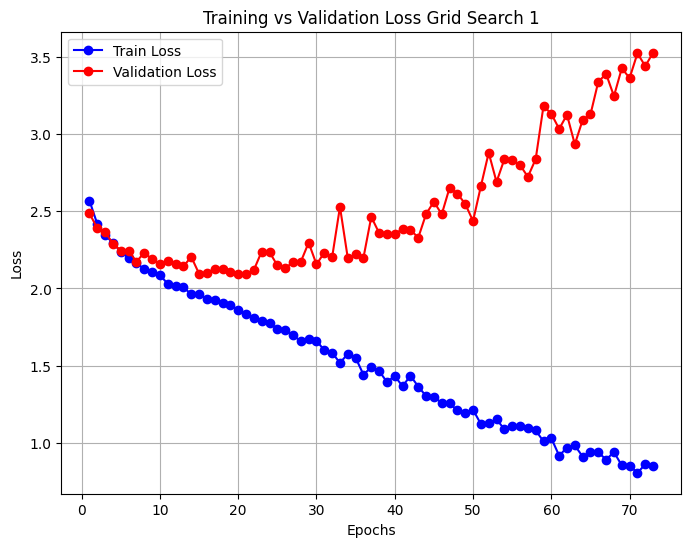

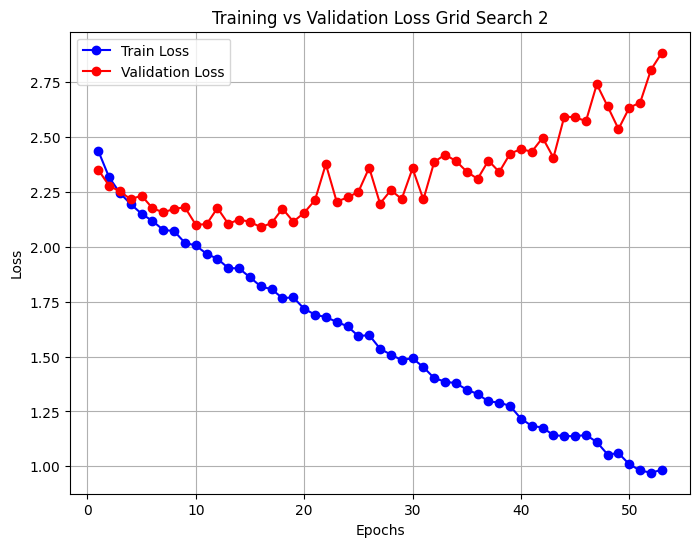

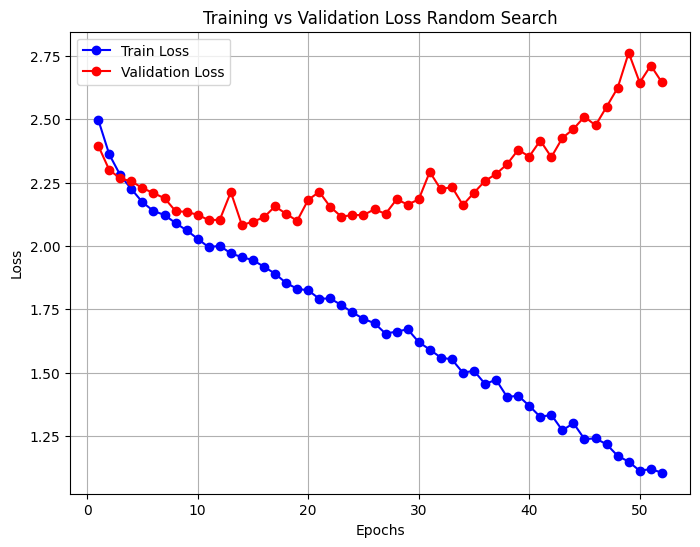

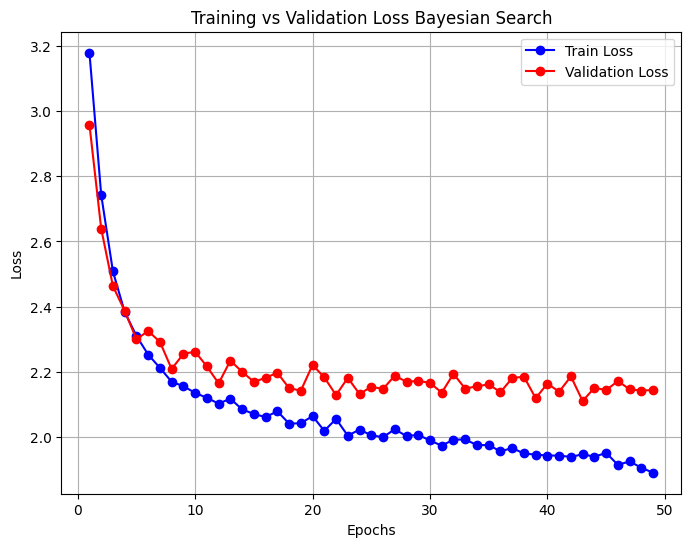

In [ ]:
train_loss = history_g1.history["loss"]
val_loss = history_g1.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Train Loss", color="blue", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Grid Search 1")
plt.legend()
plt.grid(True)
plt.show()


train_loss = history_g2.history["loss"]
val_loss = history_g2.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Train Loss", color="blue", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Grid Search 2")
plt.legend()
plt.grid(True)
plt.show()

train_loss = history_r.history["loss"]
val_loss = history_r.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Train Loss", color="blue", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Random Search")
plt.legend()
plt.grid(True)
plt.show()

train_loss = history_b.history["loss"]
val_loss = history_b.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Train Loss", color="blue", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Bayesian Search")
plt.legend()
plt.grid(True)
plt.show()

*MIXING UP THE TEST SET*

Next up we will analyze how our models perform when we rotate or zoom the images in or out.
Rotating the images (90, 180 or 270 degrees) makes our models perform very poor, only slightly better than random guessing.
Zooming in or out also affects the test accuracy, although to a much lower extent.
This makes sense if we look at how an MLP works. When zooming in or out, most of the features remain intact. An MLP considers each pixel as a separate feature, so rotating a picture causes a drastic reordering of the pixels, resulting in very poor performance. The solution to these problems would be to use a convolutional neural network.

In [ ]:
loss_g1, accuracy_g1 = model_grid1.evaluate(X_test_r, y_test_r)
print(f"Test Accuracy G1: {accuracy_g1:.4f}")
loss_g2, accuracy_g2 = model_grid2.evaluate(X_test_r, y_test_r)
print(f"Test Accuracy G2: {accuracy_g2:.4f}")
loss_r, accuracy_r = model_random.evaluate(X_test_r, y_test_r)
print(f"Test Accuracy R: {accuracy_r:.4f}")
loss_b, accuracy_b = model_bayesian.evaluate(X_test_r, y_test_r)
print(f"Test Accuracy B: {accuracy_b:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1009 - loss: 4.6476
Test Accuracy G1: 0.1195
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1226 - loss: 3.5671
Test Accuracy G2: 0.1170
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1054 - loss: 3.4983
Test Accuracy R: 0.1155
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1064 - loss: 2.7636
Test Accuracy B: 0.1290


In [ ]:
loss_g1, accuracy_g1 = model_grid1.evaluate(X_test_zi, y_test_zi)
print(f"Test Accuracy G1: {accuracy_g1:.4f}")
loss_g2, accuracy_g2 = model_grid2.evaluate(X_test_zi, y_test_zi)
print(f"Test Accuracy G2: {accuracy_g2:.4f}")
loss_r, accuracy_r = model_random.evaluate(X_test_zi, y_test_zi)
print(f"Test Accuracy R: {accuracy_r:.4f}")
loss_b, accuracy_b = model_bayesian.evaluate(X_test_zi, y_test_zi)
print(f"Test Accuracy B: {accuracy_b:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2425 - loss: 4.0154
Test Accuracy G1: 0.2300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2299 - loss: 3.0814
Test Accuracy G2: 0.2140
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2483 - loss: 2.9111
Test Accuracy R: 0.2420
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2103 - loss: 2.3727
Test Accuracy B: 0.2380


In [ ]:
loss_g1, accuracy_g1 = model_grid1.evaluate(X_test_zo, y_test_zo)
print(f"Test Accuracy G1: {accuracy_g1:.4f}")
loss_g2, accuracy_g2 = model_grid2.evaluate(X_test_zo, y_test_zo)
print(f"Test Accuracy G2: {accuracy_g2:.4f}")
loss_r, accuracy_r = model_random.evaluate(X_test_zo, y_test_zo)
print(f"Test Accuracy R: {accuracy_r:.4f}")
loss_b, accuracy_b = model_bayesian.evaluate(X_test_zo, y_test_zo)
print(f"Test Accuracy B: {accuracy_b:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2706 - loss: 3.7432
Test Accuracy G1: 0.2430
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2842 - loss: 2.9472
Test Accuracy G2: 0.2460
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2726 - loss: 2.8543
Test Accuracy R: 0.2425
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2761 - loss: 2.2747
Test Accuracy B: 0.2405


*CONCLUSION*

We investigated different hyperparameter optimization methods (Grid Search, Random Search, and Bayesian Optimization) to develop an optimal MLP model. Grid Search produced the highest-performing model, achieving the best validation and test accuracy.

The results indicated that models with 3–5 layers and 96–128 neurons per layer yielded the best performance, while higher L2 regularization values led to decreased accuracy. Bayesian Optimization, despite its theoretical advantages, did not outperform the other methods, likely due to the complexity of the search space.

The model that performed the best on the test set is also the one that had the highest validation accuracy.

Testing on transformed datasets (rotated and zoomed images) revealed significant performance degradation, particularly for rotated images. This outcome aligns with the expected behavior of fully connected networks, which lack spatial awareness. Zoom transformations had a less severe impact, but accuracy was still reduced. These findings suggest that convolutional neural networks (CNNs), which are designed to recognize spatial patterns, could provide a more robust solution for this classification task.

Overall, systematic hyperparameter tuning proved crucial for optimizing model performance. The results highlight both the strengths and limitations of MLPs in image classification, emphasizing the need for architecture selection based on dataset characteristics.

To achieve a significant increase in accuracy, especially on transformed images, convolutional neural networks should be used instead of MLPs. CNNs are designed to recognize spatial patterns and are more robust to image variations such as rotation and scaling.